In [1]:
import os
import librosa
import IPython
import numpy as np
import pandas as pd
import scipy.signal
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
%matplotlib inline

from pathlib import Path
from laughter_classification import SSPNetDataSampler
from laughter_prediction import Predictor, FeatureExtractor, sample_by_frames

# Dataset

## Noise

In [2]:
def add_noise(source, noise, destination):
    if not destination.exists():
        destination.mkdir()
    
    noises = list(noise.glob('*.wav'))

    for file in source.glob('*.wav'):
        audio, rate = librosa.load(file)
        index = np.random.randint(len(noises))
        noise_audio, noise_rate = librosa.load(noises[index])
        noise_audio = librosa.resample(noise_audio, noise_rate, rate)
        audio += noise_audio[:len(audio)]
        audio = librosa.resample(audio, rate, 16_000)
        librosa.output.write_wav(destination / file.parts[-1], audio, 16_000)

In [3]:
NOISE_PATH = Path('noise')
SOURCE_PATH = Path('vocalizationcorpus_small/data')
DESTINATION_PATH = Path('noisecorpus_small/data')

In [132]:
%%time
add_noise(SOURCE_PATH, NOISE_PATH, DESTINATION_PATH)

CPU times: user 12.7 s, sys: 53.5 ms, total: 12.7 s
Wall time: 12.8 s


## Loading

In [4]:
RATE = 16_000
MODEL_PATH = 'model.h5'
CORPUS_PATH = 'vocalizationcorpus_small'
CORPUS_NOISE_PATH = 'noisecorpus_small'
DATASET_PATH = 'dataset.csv.gz'

In [5]:
%%time

if os.path.exists(DATASET_PATH):
    print('Loading...')
    df = pd.read_csv(DATASET_PATH, compression='gzip')
else:
    sampler = SSPNetDataSampler(CORPUS_PATH)
    df = sampler.create_sampled_df(frame_sec=0.050, naudio=1000)
    df = df.reset_index(drop=True)

CPU times: user 13.7 s, sys: 307 ms, total: 14 s
Wall time: 14 s


In [6]:
df.head()

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V792,V793,V794,V795,V796,V797,V798,V799,IS_LAUGHTER,SNAME
0,-291.0,-308.0,-230.0,-213.0,-252.0,48.0,-49.0,-113.0,-165.0,-93.0,...,-197.0,124.0,-143.0,-430.0,45.0,959.0,865.0,-102.0,0,S0088
1,-367.0,-467.0,-470.0,-247.0,-459.0,-443.0,-503.0,-455.0,-193.0,-90.0,...,80.0,219.0,418.0,280.0,212.0,66.0,46.0,313.0,0,S0088
2,-493.0,417.0,12.0,-761.0,290.0,502.0,-355.0,-377.0,314.0,180.0,...,296.0,384.0,179.0,-37.0,-95.0,100.0,-117.0,-75.0,0,S0088
3,17.0,-264.0,-70.0,84.0,32.0,31.0,3.0,80.0,176.0,109.0,...,114.0,159.0,138.0,104.0,135.0,328.0,212.0,30.0,0,S0088
4,176.0,254.0,42.0,59.0,77.0,101.0,99.0,71.0,108.0,29.0,...,-105.0,-268.0,-244.0,-125.0,-237.0,-144.0,-194.0,-314.0,0,S0088


# Features

In [7]:
%%time

extractor = FeatureExtractor()
features = extractor.extract_features(df.iloc[:, :-2].as_matrix(), RATE)
features['id'] = df.SNAME
features = features.set_index('id') 

CPU times: user 1min 18s, sys: 1.22 s, total: 1min 20s
Wall time: 1min 19s


In [8]:
target = pd.DataFrame({'id': df.SNAME.values, 'target': df.IS_LAUGHTER.values})
target = target.set_index('id')

In [9]:
features.head()

,FBANK1,FBANK2,FBANK3,FBANK4,FBANK5,FBANK6,FBANK7,FBANK8,FBANK9,FBANK10,...,MFCC4,MFCC5,MFCC6,MFCC7,MFCC8,MFCC9,MFCC10,MFCC11,MFCC12,MFCC13
id,,,,,,,,,,,,,,,,,,,,,
S0088,-5.515871,-4.871016,-13.508421,-13.245243,-18.820693,-8.681309,-10.373615,-7.520968,0.000000,-1.772272,...,22.395239,-6.803403,1.440752,-5.390277,10.110229,-8.549250,-11.318820,-3.293435,-2.550721,1.027821
S0088,-13.900548,-9.552691,-12.311892,-10.566696,-13.933002,-10.907811,-8.835915,-9.652272,-5.225648,-1.798149,...,23.751832,-4.608194,7.626130,-14.824233,10.036781,-4.511768,-17.330286,-8.141089,5.918026,0.248845
S0088,-5.789022,-4.371773,-6.774558,-8.845997,-9.049552,0.000000,-7.702256,-8.415910,-0.391320,-0.905621,...,28.071602,-11.134253,9.209729,-9.593948,10.338911,-0.241882,2.228088,-7.066444,5.467714,2.226213
S0088,-4.530528,-0.019750,-2.798665,-12.194416,-4.433145,-2.498361,-0.452340,-5.383397,-6.798115,-6.579161,...,17.362597,-4.212049,4.324702,-4.905710,12.622821,-2.389607,-1.032003,-3.403436,-2.405330,0.919065
S0088,-7.925093,-1.875651,-1.410987,-7.056510,-8.567342,-4.976033,-1.272892,-6.314050,-4.889942,-3.637279,...,20.824732,-12.022200,6.335559,-7.469805,15.341983,-7.869667,-9.769059,-10.027939,0.391888,6.327217


# Predictor

In [10]:
import keras

from keras.models import Model, load_model
from keras.layers import Input, Embedding, LSTM, Dense, Reshape, Dropout

/Users/rebryk/Projects/spbau/speech-env/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [11]:
class RNNPredictor(Predictor):
    def __init__(self, batch_size=32):
        self.batch_size = batch_size
        
        mfcc_input = Input(shape=[293, 13], dtype='float32', name='MFCC_input')
        fbank_input = Input(shape=[293, 128], dtype='float32', name='FBANK_input')
        
        lstm_out = LSTM(32, return_sequences=True)(mfcc_input)
        auxiliary_output = Dense(1, activation='sigmoid', name='aux_output')(lstm_out)

        layer = keras.layers.concatenate([lstm_out, fbank_input], axis=2)
        layer = Dense(32, activation='relu')(layer)
        layer = Dropout(0.5)(layer)
        layer = Dense(32, activation='relu')(layer)
        layer = Dropout(0.5)(layer)
        layer = Dense(32, activation='relu')(layer)
        output = Dense(1, activation='sigmoid', name='main_output')(layer)
        
        self.model = Model(inputs=[mfcc_input, fbank_input], outputs=[output, auxiliary_output])
        self.model.compile(optimizer='rmsprop', loss='binary_crossentropy', loss_weights=[1., 1.])
    
    def fit(self, X, y, epochs=50):
        X_mfcc, X_fbank = X[:, :, -13:], X[:, :, :128]
        self.model.fit([X_mfcc, X_fbank], [y, y], epochs=epochs, batch_size=self.batch_size)
    
    def predict(self, X):
        return np.array(self.predict_proba(X) > 0.5, dtype=int)
    
    def predict_proba(self, X):
        X_mfcc, X_fbank = X[:, :, -13:], X[:, :, :128]
        output, _ = self.model.predict([X_mfcc, X_fbank], batch_size=self.batch_size)
        return output.squeeze()
    
    def save_model(self, path):
        self.model.save(path)
        
    def load_model(self, path):
        self.model = load_model(path)

# Testing

In [12]:
from sklearn import metrics
from sklearn.model_selection import StratifiedShuffleSplit

In [13]:
def auc(y_true, y_prob):
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_prob)
    return metrics.auc(fpr, tpr)

In [14]:
X = np.array([group.values for _, group in features.groupby('id')])
y = np.array([group.values for _, group in target.groupby('id')])

In [15]:
has_target = y.squeeze().sum(axis=1) > 0
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
train_index, val_index = list(sss.split(X, has_target))[0]

In [16]:
X_train, y_train = X[train_index], y[train_index]
X_val, y_val = X[val_index], y[val_index]

In [17]:
predictor = RNNPredictor()

if os.path.exists(MODEL_PATH):
    predictor.load_model(MODEL_PATH)
else:
    predictor.fit(X_train, y_train, epochs=100)
    predictor.save_model(MODEL_PATH)

In [18]:
y_pred = predictor.predict_proba(X_val)

In [19]:
print(f'AUC: {auc(y_val.reshape(-1), y_pred.reshape(-1)):0.3f}')

AUC: 0.856


# Examples

In [37]:
def draw_sound(features, features_noise, y_true):
    y_pred = predictor.predict_proba(np.array([features, features_noise]))
    ax = plt.subplots(1, 1, figsize=(8, 4))
    
    plt.xlabel('Frame')
    plt.ylabel('Probability')
    
    line_y_pred, = plt.plot(y_pred[0], label='Prediction')
    line_y_pred_noise, = plt.plot(y_pred[1], label='Prediction (noise)')
    line_y_true, = plt.plot(y_true, label='Target')
    plt.legend(handles=[line_y_pred, line_y_pred_noise, line_y_true])

In [38]:
def play_audio(path):
    audio, rate = librosa.load(path)
    frames = sample_by_frames(audio, rate, 3 * rate // 4)
    return IPython.display.Audio(data=audio, rate=rate)

In [39]:
sampler_noise = SSPNetDataSampler('noisecorpus_small')
df_noise = sampler_noise.create_sampled_df(frame_sec=0.050, naudio=10)
df_noise = df_noise.reset_index(drop=True)

In [40]:
features_noise = extractor.extract_features(df_noise.iloc[:, :-2].as_matrix(), RATE)
features_noise['id'] = df_noise.SNAME
features_noise = features_noise.set_index('id') 

In [41]:
target_noise = pd.DataFrame({'id': df_noise.SNAME.values, 'target': df_noise.IS_LAUGHTER.values})
target_noise = target_noise.set_index('id')

## Example 1

In [42]:
audio_name = 'S0009'

In [43]:
play_audio(f'vocalizationcorpus/data/{audio_name}.wav')

In [44]:
play_audio(f'noisecorpus_small/data/{audio_name}.wav')

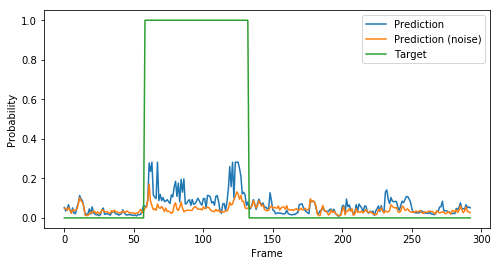

In [45]:
draw_sound(features.loc[audio_name].as_matrix(), 
           features_noise.loc[audio_name].as_matrix(), 
           target.loc[audio_name].as_matrix())

## Example 2

In [46]:
audio_name = 'S0006'

In [47]:
play_audio(f'vocalizationcorpus/data/{audio_name}.wav')

In [48]:
play_audio(f'noisecorpus_small/data/{audio_name}.wav')

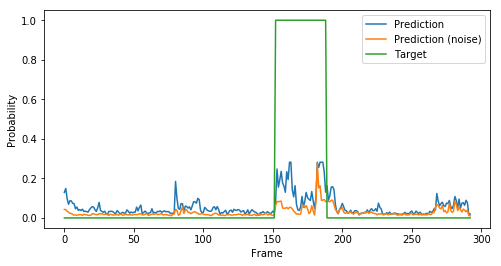

In [49]:
draw_sound(features.loc[audio_name].as_matrix(), 
           features_noise.loc[audio_name].as_matrix(), 
           target.loc[audio_name].as_matrix())

## Example 3

In [50]:
audio_name = 'S0003'

In [51]:
play_audio(f'vocalizationcorpus/data/{audio_name}.wav')

In [52]:
play_audio(f'noisecorpus_small/data/{audio_name}.wav')

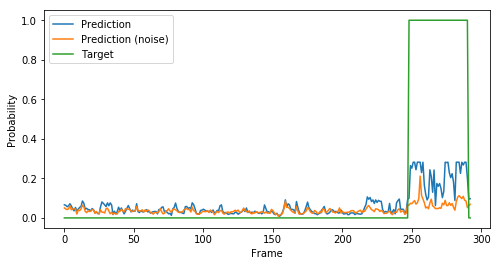

In [53]:
draw_sound(features.loc[audio_name].as_matrix(), 
           features_noise.loc[audio_name].as_matrix(), 
           target.loc[audio_name].as_matrix())